# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).


**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [2]:
import torch
import torchvision
import os
from torchvision.datasets import FakeData
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
from sklearn import metrics
import random


In [3]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True

In [4]:
torch.cuda.is_available()

True

In [5]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) # ID
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers= True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers= True)

fakeset = FakeData(size=1000, image_size=(3, 32, 32), transform=transform) # OOD
fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers= True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


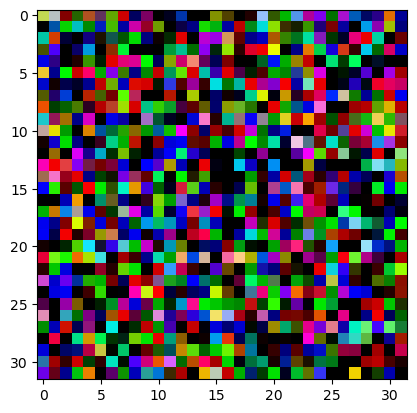

In [6]:
for data in fakeloader:
    x, y = data
    plt.imshow(x[0,:].permute(1,2,0))
    break

x.shape, trainset.classes[y[0]]

trainset.classes
class_dict = {class_name:id_class for id_class, class_name in enumerate(trainset.classes)} 

In [7]:
trainset.classes[y[0]]

'horse'

In [8]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # downsample
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # downsample
        
        self.flatten_dim = 256 * 8 * 8  # assuming input is 32x32
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # -> 32x32x32
        x = F.relu(self.conv2(x))   # -> 32x32x64
        x = F.relu(self.conv3(x))   # -> 32x32x128
        x = F.relu(self.conv4(x))   # -> 16x16x128
        x = F.relu(self.conv5(x))   # -> 8x8x256
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

loss =  nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [11]:
load_resnet = False
load = False
if not load_resnet and not load:
    epochs = 50
    for e in range(epochs):
        running_loss = 0
        for it, data in enumerate (trainloader):
            x, y = data
            x, y = x.to(device), y.to(device)
            
            yp = model(x)
            l = loss(yp, y)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            running_loss += l.item()
            #if it % 100 == 0:
            #    print(it, l.item())
        print(e, running_loss/len(trainloader))
    torch.save(model.state_dict(), f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth')      

0 1.807930308229783
1 1.4450053247954229
2 1.2988207828053429
3 1.1959000597219638
4 1.1165242079273818
5 1.0365046349632772
6 0.9579973983032929
7 0.8818195315882983
8 0.806871850472277
9 0.7254298452830985
10 0.6452681968736527
11 0.5589673770663074
12 0.47007113809475815
13 0.3811820787770669
14 0.29329195024107424
15 0.218338867625617
16 0.15199577490158397
17 0.11600445546305088
18 0.08965637802105883
19 0.06753074539267956
20 0.07127199379150825
21 0.057463038515042315
22 0.04846412971344255
23 0.043985118343949775
24 0.04229425726329808
25 0.04880651305108081
26 0.04750969410633378
27 0.029498712826625008
28 0.039393273762205756
29 0.03308975313732977
30 0.04218938080963138
31 0.028406203559497394
32 0.03888813368356822
33 0.02250230248572062
34 0.025116819913958765
35 0.025902548961191322
36 0.03365494924165127
37 0.029862550692573247
38 0.020662697490311854
39 0.02408575861866031
40 0.017303122678394085
41 0.034257553339771485
42 0.029523552942346983
43 0.01635907657022881
44 

In [12]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.

if load:
    model = CNN().to(device)
    model.load_state_dict(torch.load('./cifar10_CNN.pth')) #fully trained
    #model.load_state_dict(torch.load(f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth'))

In [13]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.

if load_resnet:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
    model.eval()
    model.cuda()

In [14]:
# Here we test the model on test data collecting all predictions
model.eval()
y_gt, y_pred = [], []
for it, data in enumerate (testloader):
    x, y = data
    x, y = x.to(device), y.to(device)

    yp = model(x)

    y_pred.append(yp.argmax(1))
    y_gt.append(y)

Accuracy: 0.623199999332428


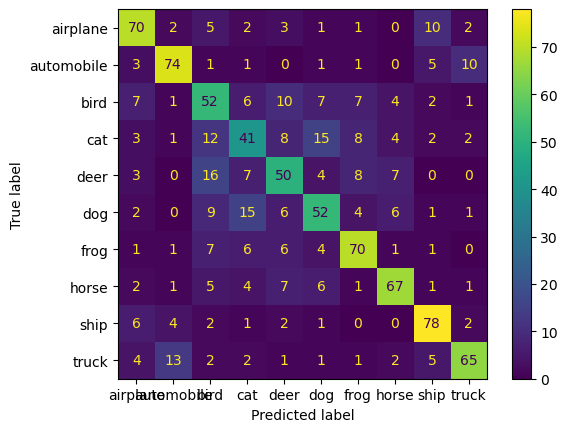

In [15]:
# Here we look at accuracy and confusion matrix
y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
print(f'Accuracy: {accuracy}')

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)

cmn = (100*cmn).astype(np.int32)
disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
disp.plot()
plt.show()

In [16]:
cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)
print(f'Per class accuracy: {np.diag(cmn).mean():.4f}')

Per class accuracy: 0.6232


In [17]:
for data in testloader:
    x, y = data
    #plt.imshow(x[0,:].permute(1,2,0))
    break

for data in fakeloader:
    xfake, _ = data
    #plt.imshow(x[0,:].permute(1,2,0))
    break

GT: 9, truck


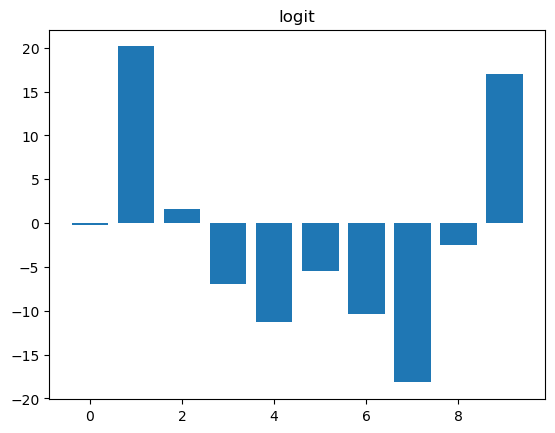

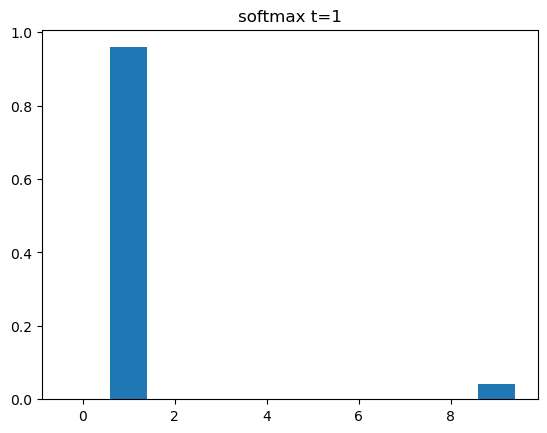

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


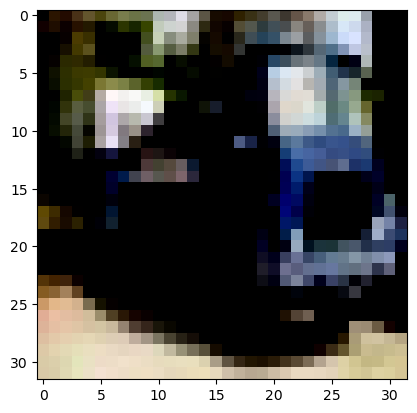

In [18]:
import random
# Example of logit and softmax output
# k=0 # the kth sample of the batch
k=random.randint(0,x.shape[0])
print(f'GT: {y[k]}, {testset.classes[y[k]]}')#the corresponding label
output = model(x.cuda())
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(x[k,:].permute(1,2,0))
plt.show()

In [19]:
x.shape

torch.Size([128, 3, 32, 32])

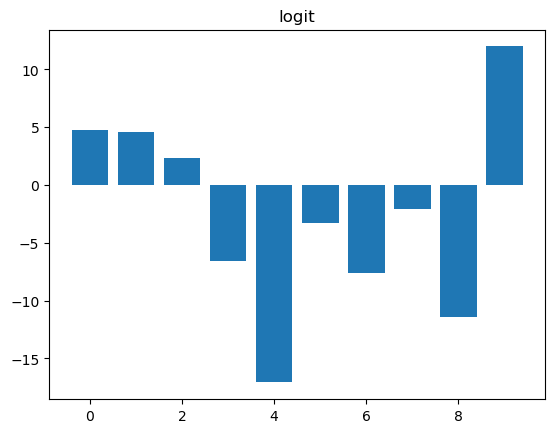

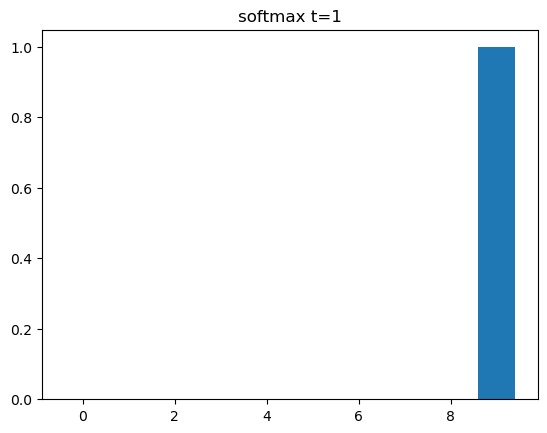

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


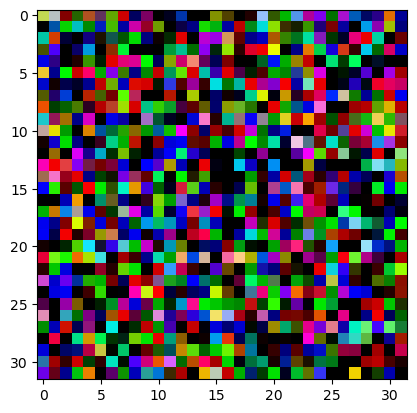

In [20]:
# Example of logit and softmax output
k=0 # the kth sample of the batch
output = model(xfake.cuda())
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(xfake[0,:].permute(1,2,0))
plt.show()

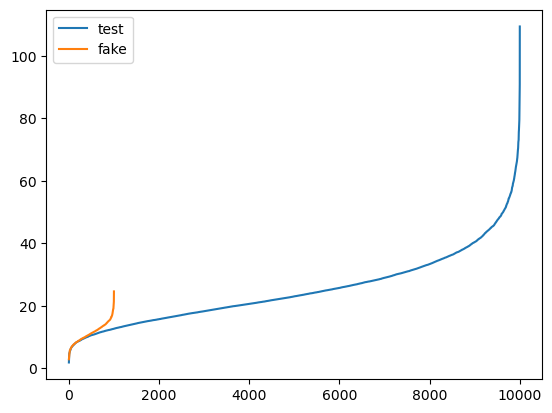

In [21]:
def max_logit(logit):
    s = logit.max(dim=1)[0] #get the max for each element of the batch
    return s

def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    s = s.max(dim=1)[0] #get the max for each element of the batch
    return s


def compute_scores(data_loader, score_fun):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_fun(output)
            scores.append(s)
        scores_t = torch.cat(scores)
        return scores_t

temp = 1
#scores_test = compute_scores(testloader, lambda l: max_softmax(l, T=temp))
#scores_fake = compute_scores(fakeloader, lambda l: max_softmax(l, T=temp))

scores_test = compute_scores(testloader, max_logit)
scores_fake = compute_scores(fakeloader, max_logit)
      
plt.plot(sorted(scores_test.cpu()),label='test')
plt.plot(sorted(scores_fake.cpu()),label='fake')
plt.legend()

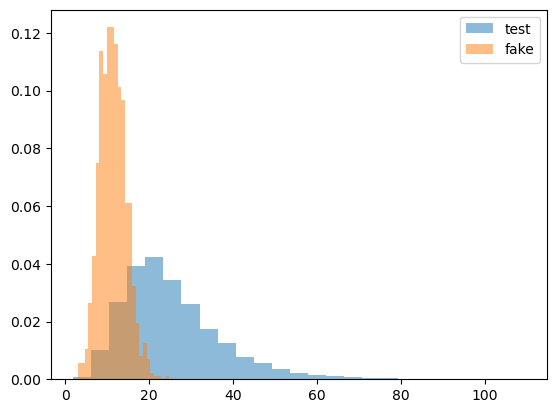

In [22]:
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25,label='test')
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25,label='fake')
plt.legend()
plt.show()

In [73]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [74]:
model_ae = Autoencoder().to(device)

mse_loss =  nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.0001)

In [75]:
epochs = 20
for e in range(epochs):
    running_loss = 0
    for it, data in enumerate (trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        
        z, x_rec = model_ae(x)
        l = mse_loss(x, x_rec)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        running_loss += l.item()
        #if it % 100 == 0:
        #    print(it, l.item())
    print(e, running_loss/len(trainloader))

0 0.31808402002467523
1 0.20284028130266674
2 0.18858346682222907
3 0.17761055892690672
4 0.17146304741387478
5 0.1684332361916447
6 0.16604656293569015
7 0.16274913547136594
8 0.160470950100428
9 0.1590212518373109
10 0.15792318138167682
11 0.15702993706669038
12 0.1563206364965195
13 0.15573766271171668
14 0.15519114532281675
15 0.15469217864448762
16 0.15409694469112264
17 0.15356376820513049
18 0.15309834990964827
19 0.15265070416433427


In [76]:
model_ae.eval()
#use negative MSE since higher error means OOD
loss = nn.MSELoss(reduction='none')

scores_fake_ae = []
with torch.no_grad():
    for data in fakeloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_fake_ae.append(-score)
        
scores_fake_ae = torch.cat(scores_fake_ae)


scores_test_ae = []
with torch.no_grad():
    for data in testloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_test_ae.append(-score)
        
scores_test_ae = torch.cat(scores_test_ae)

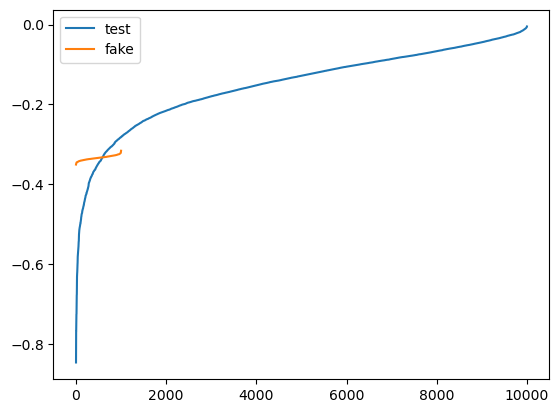

In [77]:
plt.plot(sorted(scores_test_ae.cpu()))
plt.plot(sorted(scores_fake_ae.cpu()))
plt.legend(['test','fake'])

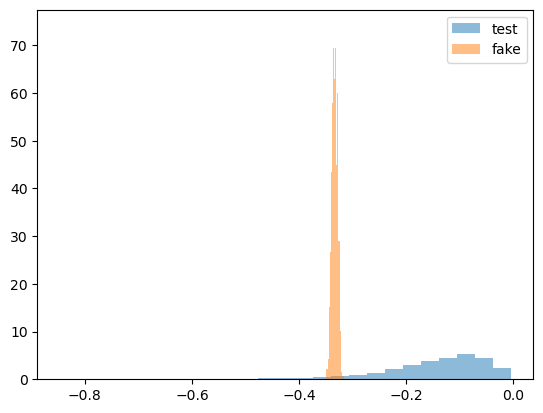

In [78]:
plt.hist(scores_test_ae.cpu(), density=True, alpha=0.5, bins=25, label='test')
plt.hist(scores_fake_ae.cpu(), density=True, alpha=0.5, bins=25, label='fake')
plt.legend() 
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



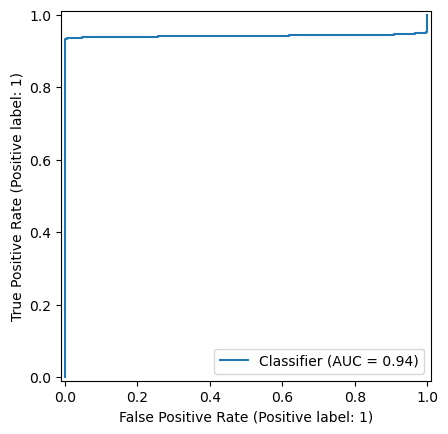

In [79]:
# AE performance
ypred =  torch.cat((scores_test_ae, scores_fake_ae))
y_test = torch.ones_like(scores_test_ae)
y_fake = torch.zeros_like(scores_fake_ae)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

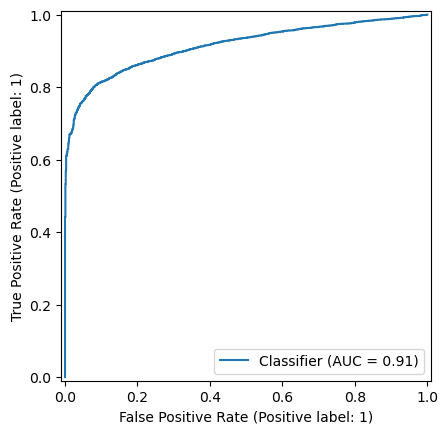

In [80]:
#logits or softmax performance
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [23]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = - mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [82]:
for i,c in enumerate(testset.classes):
    print(i, c)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


sample id: 17


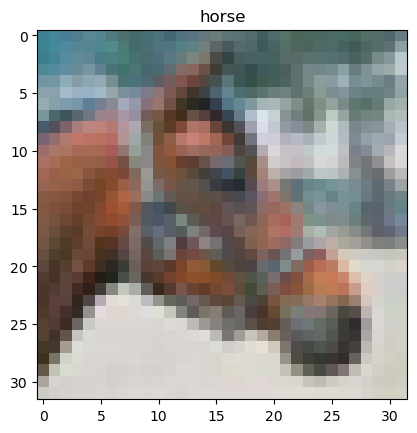

Attack!!
7 7
0 7
Untargeted attack success! budget:2/255


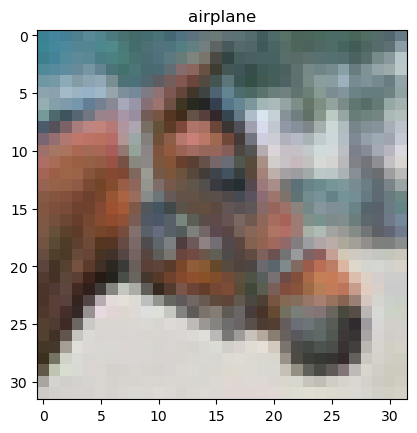

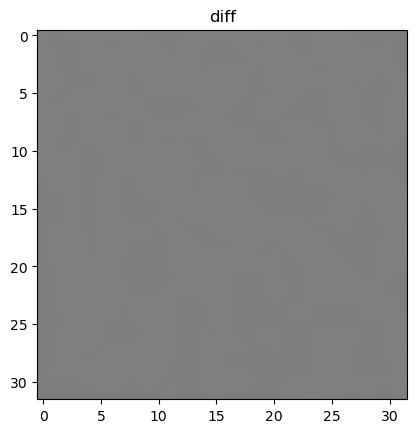

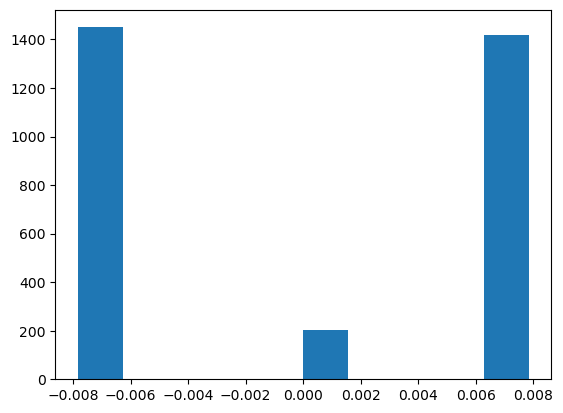

In [87]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in testloader:
    x, y = data
    break
########## CONFIG ###########

targeted_attack = False # False for untargeted
target_label = class_dict['deer']
eps = 1/255 #set the budget for each step
sample_id = random.randint(0,len(testloader)) #select id of test set sample to try to attack (id=17 attack)
print(f'sample id: {sample_id}')

######### END ##############

x, y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:]
y = y[None]

x.requires_grad=True  
#print(x)

before = x.clone()
output = model(x)
#print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(testset.classes[output.argmax()])
plt.show()

if output.argmax().item() !=  y.item() or y.item() == target_label:
    print('classifier is already wrong or target label same as GT!')
else:
    done = False
    print('Attack!!')
    n = 0
    # only attack if y==model(x)
    # target = torch.tensor(y).unsqueeze(0).cuda()
    if targeted_attack:
        target = torch.tensor(target_label).unsqueeze(0).cuda()
        print(f'target: {testset.classes[target.squeeze()]}')
   
    while not done: # untargeted attack until success!
    
        x.retain_grad()

        output = model(x)

        model.zero_grad()

        if targeted_attack:
            yt = target # targeted
        else:
            yt = y # untargeted
        
        l = loss(output,yt)
        l.backward()

        if targeted_attack:
            x = x - eps * torch.sign(x.grad) # FGSM targeted
        else:
            x = x + eps * torch.sign(x.grad) # FGSM untargeted
        
        n += 1

        print(output.argmax().item(),  y.item())
        if not targeted_attack and output.argmax().item()!=  y.item():
            print(f'Untargeted attack success! budget:{int(255 * n * eps)}/255')
            done=True
        
        if targeted_attack and output.argmax().item() == target:
            
            print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255 * n * eps)}/255')
            done=True
            
   
    img = inv(x.squeeze())
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    diff = (x - before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())

In [88]:
x.shape

torch.Size([1, 3, 32, 32])

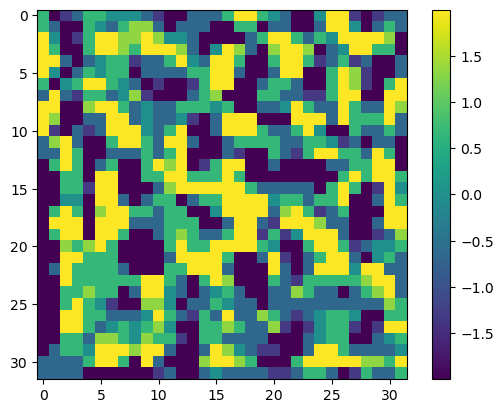

In [89]:
diff.squeeze().mean(0).shape
plt.imshow(255 * diff.cpu().detach().squeeze().mean(0))
plt.colorbar()

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10, FakeData
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [48]:
# 1. Funzione FGSM riutilizzabile 
def fgsm_attack(model, criterion, x, y, epsilon, targeted_attack=False):
    """
    Genera un batch di esempi avversari usando il Fast Gradient Sign Method (FGSM).
    Questo è un attacco "untargeted".
    """
    x.requires_grad = True

    # Forward pass 
    output = model(x)
    loss = criterion(output, y)

    # Backward pass 
    model.zero_grad()
    loss.backward()

    grad = x.grad.data
    
    if targeted_attack:
        x_adv = x - epsilon * grad.sign()
    else:
        x_adv = x + epsilon * grad.sign()
    
    x_adv = torch.clamp(x_adv, -1, 1)
    
    return x_adv.detach() 

In [93]:
# 2. Re-inizializziamo il modello e l'ottimizzatore 
print("Initializing a new model for adversarial training...")
robust_model = CNN().to(device)
optimizer_robust = optim.Adam(robust_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
epsilon = 2/255 # 

Initializing a new model for adversarial training...


In [94]:
# 3. Nuovo Ciclo di Addestramento con Augmentation Avversaria
epochs = 50 

print("Starting adversarial training...")
for e in range(epochs):
    running_loss = 0
    progress_bar = tqdm(trainloader, desc=f"Epoch {e+1}/{epochs}")
    
    for x, y in progress_bar:
        x, y = x.to(device), y.to(device)
        
        # on the-fly 
        x_adv = fgsm_attack(robust_model, criterion, x.clone(), y, epsilon)
        
        # Combina il batch originale e quello avversario
        x_combined = torch.cat([x, x_adv])
        y_combined = torch.cat([y, y])
        
        #Addestramento sul batch combinato
        yp = robust_model(x_combined)
        l = criterion(yp, y_combined)
        
        optimizer_robust.zero_grad()
        l.backward()
        optimizer_robust.step()
        
        running_loss += l.item()
        progress_bar.set_postfix(loss=f"{l.item():.4f}")
        
    print(f"Epoch {e+1}, Average Loss: {running_loss/len(trainloader):.4f}")

print("Adversarial training complete.")

Starting adversarial training...


Epoch 1/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1, Average Loss: 1.8202


Epoch 2/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2, Average Loss: 1.5306


Epoch 3/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3, Average Loss: 1.4042


Epoch 4/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4, Average Loss: 1.3241


Epoch 5/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5, Average Loss: 1.2526


Epoch 6/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6, Average Loss: 1.1915


Epoch 7/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7, Average Loss: 1.1308


Epoch 8/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8, Average Loss: 1.0696


Epoch 9/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9, Average Loss: 1.0065


Epoch 10/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10, Average Loss: 0.9453


Epoch 11/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11, Average Loss: 0.8858


Epoch 12/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12, Average Loss: 0.8264


Epoch 13/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13, Average Loss: 0.7607


Epoch 14/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14, Average Loss: 0.6957


Epoch 15/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15, Average Loss: 0.6234


Epoch 16/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16, Average Loss: 0.5531


Epoch 17/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17, Average Loss: 0.4738


Epoch 18/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18, Average Loss: 0.4052


Epoch 19/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19, Average Loss: 0.3316


Epoch 20/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20, Average Loss: 0.2679


Epoch 21/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21, Average Loss: 0.2089


Epoch 22/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22, Average Loss: 0.1705


Epoch 23/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23, Average Loss: 0.1377


Epoch 24/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24, Average Loss: 0.1075


Epoch 25/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25, Average Loss: 0.0752


Epoch 26/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26, Average Loss: 0.0632


Epoch 27/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27, Average Loss: 0.0652


Epoch 28/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28, Average Loss: 0.0681


Epoch 29/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29, Average Loss: 0.0476


Epoch 30/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30, Average Loss: 0.0394


Epoch 31/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31, Average Loss: 0.0537


Epoch 32/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32, Average Loss: 0.0524


Epoch 33/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33, Average Loss: 0.0353


Epoch 34/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34, Average Loss: 0.0306


Epoch 35/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35, Average Loss: 0.0407


Epoch 36/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36, Average Loss: 0.0338


Epoch 37/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37, Average Loss: 0.0233


Epoch 38/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38, Average Loss: 0.0427


Epoch 39/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39, Average Loss: 0.0417


Epoch 40/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40, Average Loss: 0.0214


Epoch 41/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41, Average Loss: 0.0241


Epoch 42/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42, Average Loss: 0.0291


Epoch 43/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43, Average Loss: 0.0298


Epoch 44/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44, Average Loss: 0.0285


Epoch 45/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45, Average Loss: 0.0127


Epoch 46/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46, Average Loss: 0.0275


Epoch 47/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47, Average Loss: 0.0385


Epoch 48/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48, Average Loss: 0.0199


Epoch 49/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49, Average Loss: 0.0209


Epoch 50/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50, Average Loss: 0.0209
Adversarial training complete.


In [95]:
# 4. Valutazione del Modello Robusto (come nell'Esercizio 1)
print("\nEvaluating the robust model's OOD detection performance")

robust_model.eval()

def max_logit(logit):
    s = logit.max(dim=1)[0] # get the max for each element of the batch
    return s

def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    return s.max(dim=1)[0]

def compute_scores(data_loader, model_to_test, score_fun):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, _ = data
            output = model_to_test(x.to(device))
            s = score_fun(output)
            scores.append(s)
    return torch.cat(scores)



Evaluating the robust model's OOD detection performance


Plotting results for the robust model...


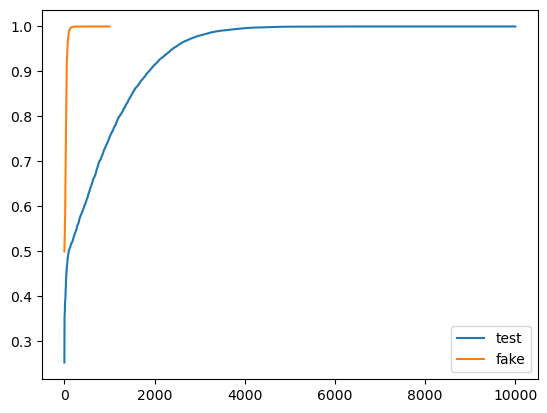

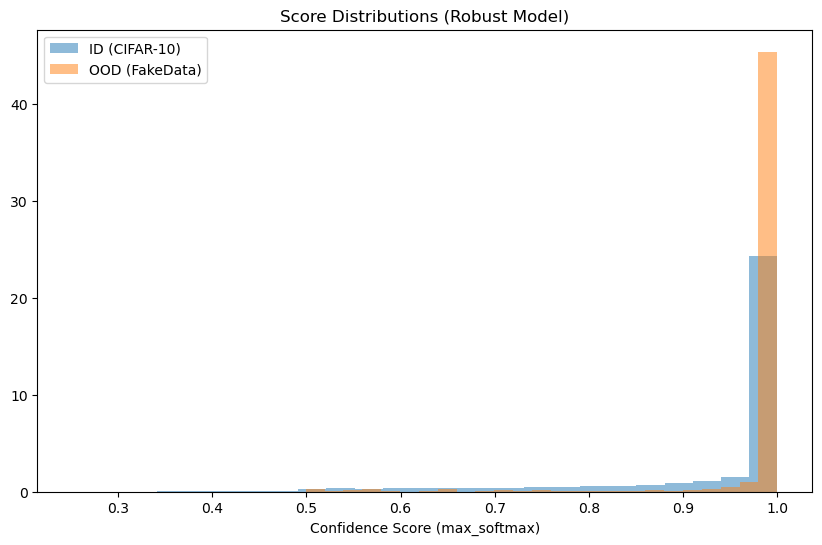

<Figure size 800x800 with 0 Axes>

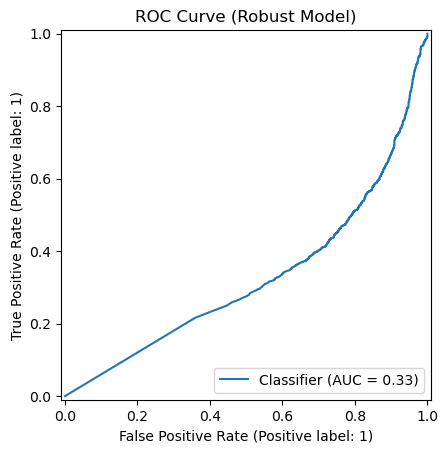

In [96]:
# Calcola i punteggi per i dati ID e OOD usando il nuovo modello robusto per la MAX SOFTMAX
scores_test_robust = compute_scores(testloader, robust_model, max_softmax)
scores_fake_robust = compute_scores(fakeloader, robust_model, max_softmax)

# 5. Visualizzazione e Analisi dei Risultati
print("Plotting results for the robust model...")

# Istogramma e curve delle distribuzioni dei punteggi
plt.plot(sorted(scores_test_robust.cpu()))
plt.plot(sorted(scores_fake_robust.cpu()))
plt.legend(['test','fake'])

plt.figure(figsize=(10, 6))
plt.hist(scores_test_robust.cpu().numpy(), density=True, alpha=0.5, bins=25, label='ID (CIFAR-10)')
plt.hist(scores_fake_robust.cpu().numpy(), density=True, alpha=0.5, bins=25, label='OOD (FakeData)')
plt.title('Score Distributions (Robust Model)')
plt.xlabel('Confidence Score (max_softmax)')
plt.legend()
plt.show()

# Curva ROC per la performance di rilevamento OOD
y_pred_robust = torch.cat((scores_test_robust, scores_fake_robust))
y_true_robust = torch.cat((torch.ones_like(scores_test_robust), torch.zeros_like(scores_fake_robust)))

plt.figure(figsize=(8, 8))
metrics.RocCurveDisplay.from_predictions(y_true_robust.cpu(), y_pred_robust.cpu())
plt.title('ROC Curve (Robust Model)')
plt.show()

Plotting results for the robust model...


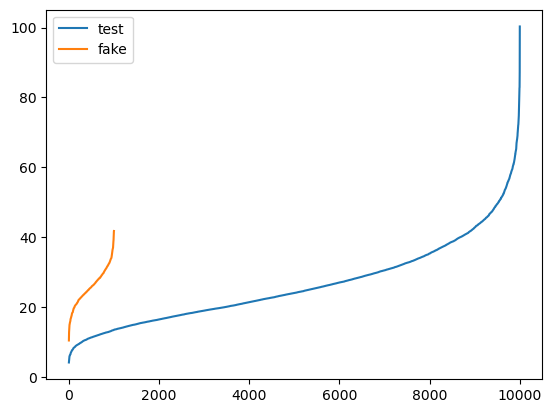

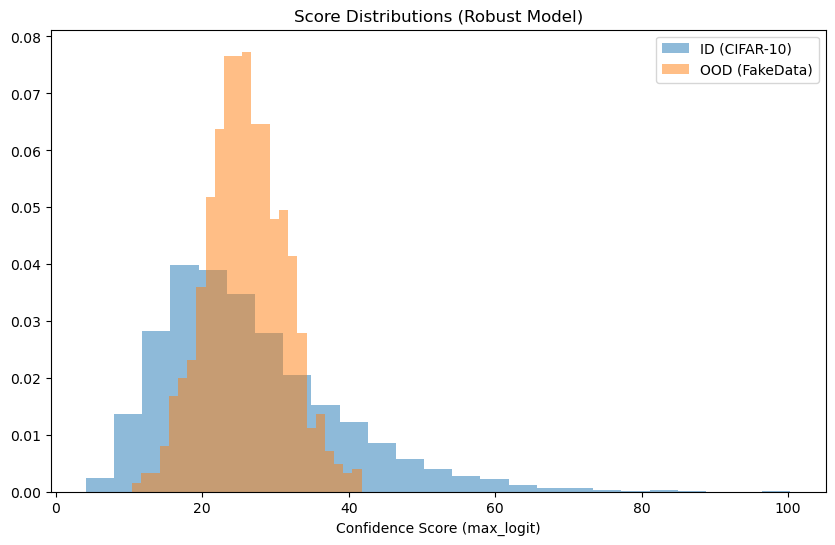

<Figure size 800x800 with 0 Axes>

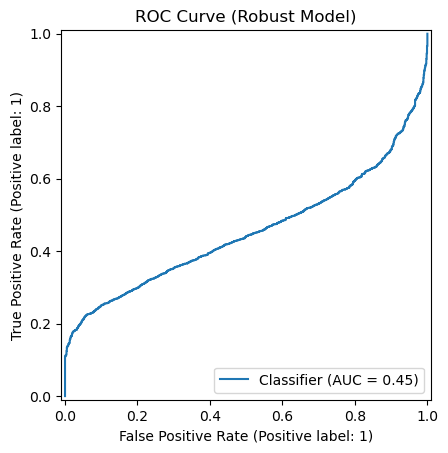

In [97]:
# Calcola i punteggi per i dati ID e OOD usando il nuovo modello robusto per la MAX LOGIT
scores_test_robust = compute_scores(testloader, robust_model, max_logit)
scores_fake_robust = compute_scores(fakeloader, robust_model, max_logit)

# --- 5. Visualizzazione e Analisi dei Risultati ---
print("Plotting results for the robust model...")

# Istogramma e curve delle distribuzioni dei punteggi
plt.plot(sorted(scores_test_robust.cpu()))
plt.plot(sorted(scores_fake_robust.cpu()))
plt.legend(['test','fake'])

plt.figure(figsize=(10, 6))
plt.hist(scores_test_robust.cpu().numpy(), density=True, alpha=0.5, bins=25, label='ID (CIFAR-10)')
plt.hist(scores_fake_robust.cpu().numpy(), density=True, alpha=0.5, bins=25, label='OOD (FakeData)')
plt.title('Score Distributions (Robust Model)')
plt.xlabel('Confidence Score (max_logit)')
plt.legend()
plt.show()

# Curva ROC per la performance di rilevamento OOD
y_pred_robust = torch.cat((scores_test_robust, scores_fake_robust))
y_true_robust = torch.cat((torch.ones_like(scores_test_robust), torch.zeros_like(scores_fake_robust)))

plt.figure(figsize=(8, 8))
metrics.RocCurveDisplay.from_predictions(y_true_robust.cpu(), y_pred_robust.cpu())
plt.title('ROC Curve (Robust Model)')
plt.show()

---
## Exercise 3: Wildcard

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
def fgsm_attack_generic(model, loss, x, y, eps, targeted_attack=False, target_label=None, sample_id=0):
    x, y = x[sample_id].to(device), y[sample_id].to(device)

    x = x[None,:]
    y = y[None]

    x.requires_grad=True

    before = x.clone()
    x_adv = x.clone() 
    output = model(x)
    #print(output.argmax().item(),  y.item())
    img = inv(x[0])
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    if output.argmax().item() !=  y.item() or y.item() == target_label:
        print('classifier is already wrong or target label same as GT!')

    else:
        done = False
        print('Attack!!')
        n = 0
        if targeted_attack:
            target = torch.tensor(target_label).unsqueeze(0).cuda()
            print(f'target: {testset.classes[target.squeeze()]}')
    
        while not done: # untargeted attack until success!
            x.retain_grad()
            output = model(x)
            model.zero_grad()

            if targeted_attack:
                yt = target # targeted
            else:
                yt = y # untargeted
            
            l = loss(output,yt)
            l.backward()

            if targeted_attack:
                x = x - eps * torch.sign(x.grad) # FGSM targeted
            else:
                x = x + eps * torch.sign(x.grad) # FGSM untargeted
            
            x_adv = (torch.clamp(x, -1, 1)).detach()
            n += 1

            print(output.argmax().item(),  y.item())
            if not targeted_attack and output.argmax().item()!=  y.item():
                print(f'Untargeted attack success! budget:{int(255 * n * eps)}/255')
                done=True
            
            if targeted_attack and output.argmax().item() == target:
                print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255 * n * eps)}/255')
                done=True
                    
        img = inv(x.squeeze())
        plt.imshow(img.permute(1,2,0).detach().cpu())
        plt.title(testset.classes[output.argmax()])
        plt.show()

        diff = (x - before)
        diffi = inv(diff[0])
        plt.imshow(diffi.permute(1,2,0).detach().cpu())
        plt.title('diff')
        plt.show()

        diff_flat = diff.flatten()

        plt.hist(diff_flat.detach().cpu())

        diff.squeeze().mean(0).shape
        plt.imshow(255 * diff.cpu().detach().squeeze().mean(0))
        plt.colorbar()
        
    return x_adv

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.023529297..1.0000001].


sample id: 11


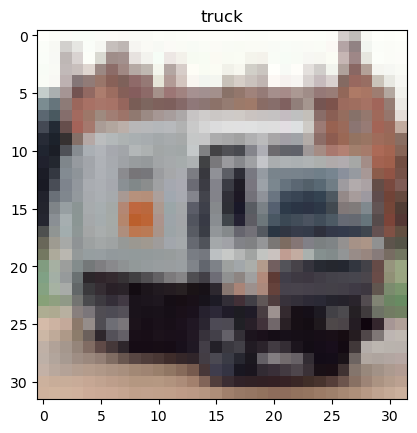

Attack!!
target: deer
9 9
9 9
9 9
9 9
9 9
1 9
1 9
1 9
1 9
1 9
1 9
1 9
1 9
1 9
1 9
1 9
1 9
7 9
7 9
7 9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04117636..1.0411773].


4 9
Targeted attack(deer) success! budget:21/255


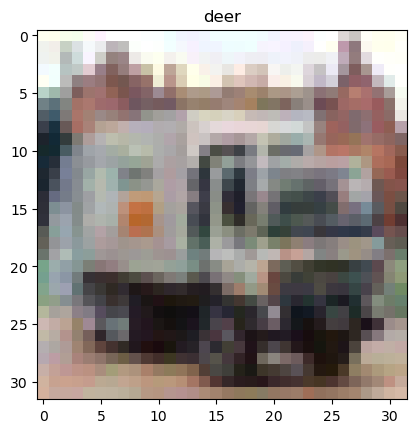

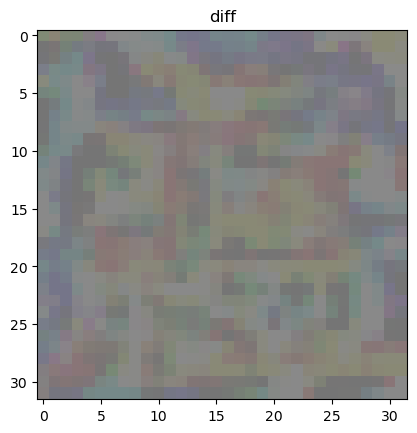

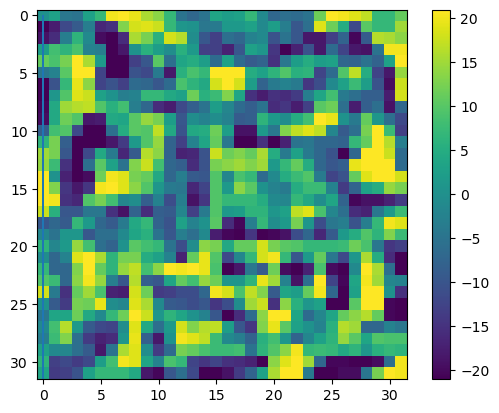

In [ ]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in testloader:
    x, y = data
    break

targeted_attack = True # False for untargeted, True for targeted attack
target_label = class_dict['deer']
eps = 1/255 # set the budget for each step
#sample_id = random.randint(0,len(testloader)) # select id of test set sample to try to attack
sample_id = 11
print(f'sample id: {sample_id}')

x_adversarial = fgsm_attack_generic(model, loss, x, y, eps, targeted_attack=targeted_attack, target_label=target_label, sample_id=sample_id)

In [ ]:
# 2. Re-inizializziamo il modello e l'ottimizzatore 
print("Initializing a new model for adversarial training...")
robust_model = CNN().to(device)
optimizer_robust = optim.Adam(robust_model.parameters(), lr=0.0001)
epochs = 50 

print("Starting adversarial training...")
for e in range(epochs):
    running_loss = 0
    progress_bar = tqdm(trainloader, desc=f"Epoch {e+1}/{epochs}")
    
    for x, y in progress_bar:
        x, y = x.to(device), y.to(device)
        
        # on the-fly 
        x_adv = fgsm_attack(robust_model, loss, x.clone(), y, eps, targeted_attack=targeted_attack) # target True
        
        # Combina il batch originale e quello avversario
        x_combined = torch.cat([x, x_adv])
        y_combined = torch.cat([y, y])
        
        #Addestramento sul batch combinato
        yp = robust_model(x_combined)
        l = loss(yp, y_combined)
        
        optimizer_robust.zero_grad()
        l.backward()
        optimizer_robust.step()
        
        running_loss += l.item()
        progress_bar.set_postfix(loss=f"{l.item():.4f}")
        
    print(f"Epoch {e+1}, Average Loss: {running_loss/len(trainloader):.4f}")

print("Adversarial training complete.")


Initializing a new model for adversarial training...
Starting adversarial training...


Epoch 1/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1, Average Loss: 1.7785


Epoch 2/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2, Average Loss: 1.4530


Epoch 3/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3, Average Loss: 1.2916


Epoch 4/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4, Average Loss: 1.1890


Epoch 5/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5, Average Loss: 1.1014


Epoch 6/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6, Average Loss: 1.0247


Epoch 7/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7, Average Loss: 0.9505


Epoch 8/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8, Average Loss: 0.8793


Epoch 9/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9, Average Loss: 0.8094


Epoch 10/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10, Average Loss: 0.7380


Epoch 11/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11, Average Loss: 0.6697


Epoch 12/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12, Average Loss: 0.5954


Epoch 13/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13, Average Loss: 0.5215


Epoch 14/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14, Average Loss: 0.4571


Epoch 15/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15, Average Loss: 0.3880


Epoch 16/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16, Average Loss: 0.3238


Epoch 17/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17, Average Loss: 0.2608


Epoch 18/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18, Average Loss: 0.2031


Epoch 19/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19, Average Loss: 0.1552


Epoch 20/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20, Average Loss: 0.1135


Epoch 21/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21, Average Loss: 0.0845


Epoch 22/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22, Average Loss: 0.0626


Epoch 23/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23, Average Loss: 0.0444


Epoch 24/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24, Average Loss: 0.0458


Epoch 25/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25, Average Loss: 0.0429


Epoch 26/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26, Average Loss: 0.0390


Epoch 27/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27, Average Loss: 0.0354


Epoch 28/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28, Average Loss: 0.0351


Epoch 29/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29, Average Loss: 0.0165


Epoch 30/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30, Average Loss: 0.0318


Epoch 31/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31, Average Loss: 0.0311


Epoch 32/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32, Average Loss: 0.0210


Epoch 33/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33, Average Loss: 0.0204


Epoch 34/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34, Average Loss: 0.0291


Epoch 35/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35, Average Loss: 0.0183


Epoch 36/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36, Average Loss: 0.0177


Epoch 37/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37, Average Loss: 0.0251


Epoch 38/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38, Average Loss: 0.0097


Epoch 39/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39, Average Loss: 0.0133


Epoch 40/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40, Average Loss: 0.0309


Epoch 41/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41, Average Loss: 0.0207


Epoch 42/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42, Average Loss: 0.0083


Epoch 43/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43, Average Loss: 0.0110


Epoch 44/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44, Average Loss: 0.0275


Epoch 45/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45, Average Loss: 0.0171


Epoch 46/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46, Average Loss: 0.0123


Epoch 47/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47, Average Loss: 0.0173


Epoch 48/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48, Average Loss: 0.0099


Epoch 49/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49, Average Loss: 0.0139


Epoch 50/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50, Average Loss: 0.0137
Adversarial training complete.

Evaluating the robust model's OOD detection performance


In [ ]:
# 4. Valutazione del Modello Robusto (come nell'Esercizio 1)
print("\nEvaluating the robust model's OOD detection performance")

def max_logit(logit):
    s = logit.max(dim=1)[0] # get the max for each element of the batch
    return s

def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    return s.max(dim=1)[0]

def compute_scores(data_loader, model_to_test, score_fun):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, _ = data
            output = model_to_test(x.to(device))
            s = score_fun(output)
            scores.append(s)
    return torch.cat(scores)

Plotting results for the robust model...


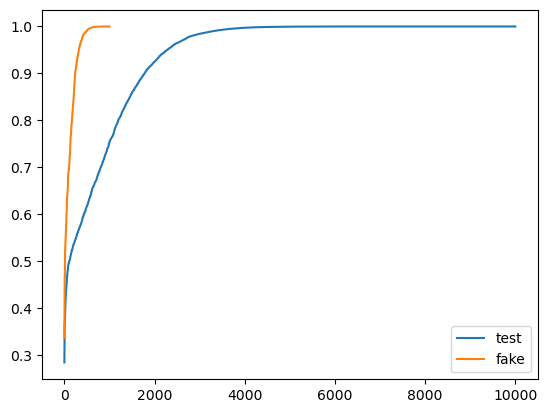

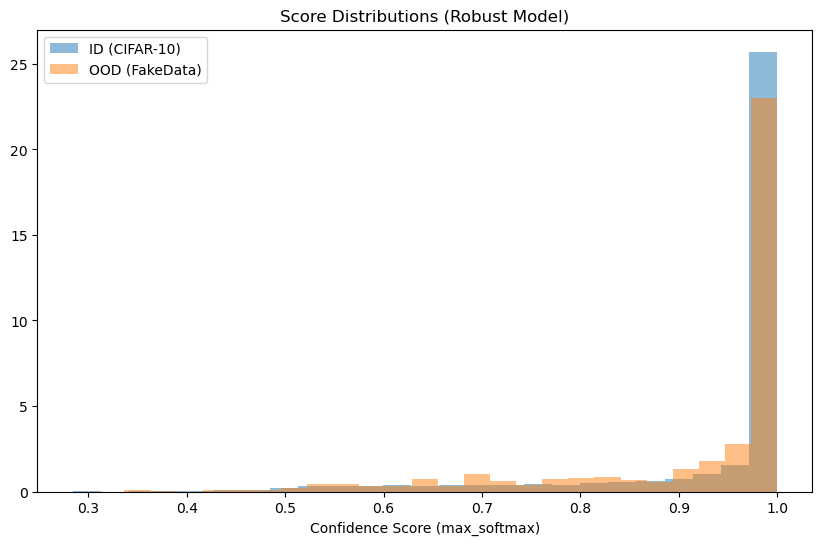

<Figure size 800x800 with 0 Axes>

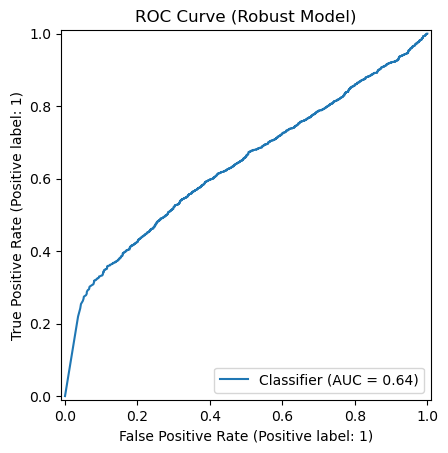

Plotting results for the robust model...


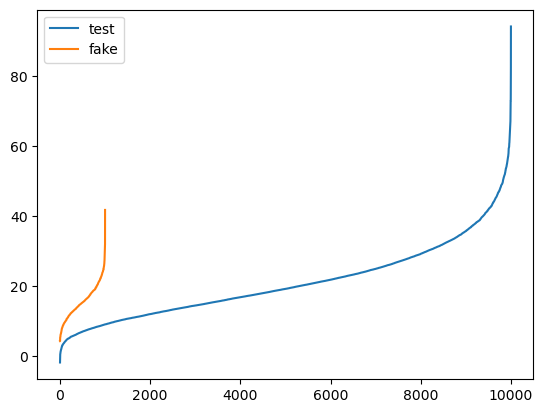

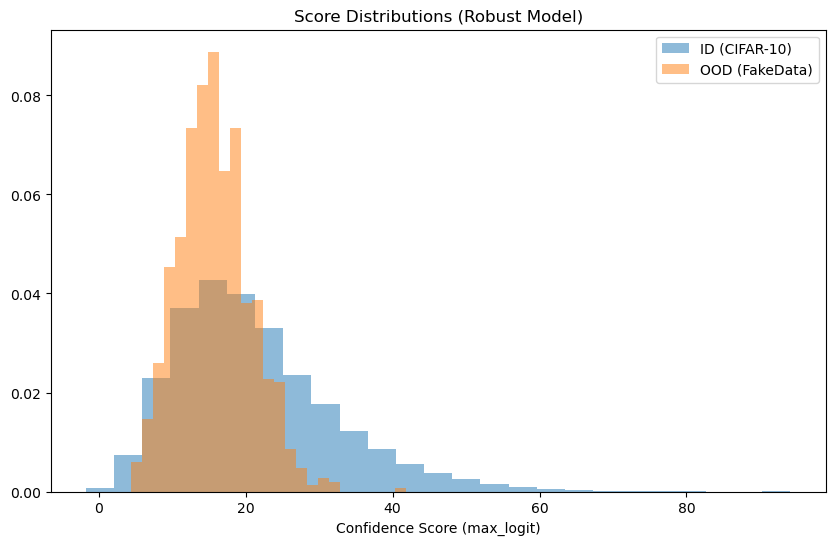

<Figure size 800x800 with 0 Axes>

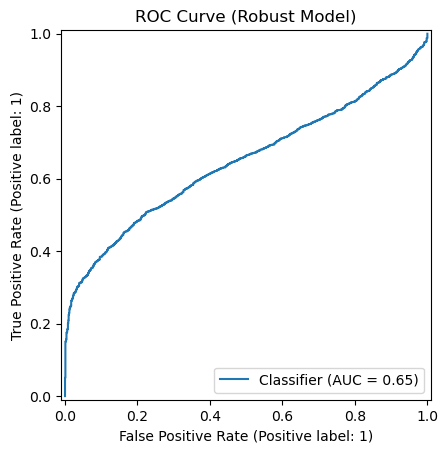

In [51]:
robust_model.eval()

# Calcola i punteggi per i dati ID e OOD usando il nuovo modello robusto per la MAX SOFTMAX
scores_test_robust = compute_scores(testloader, robust_model, max_softmax)
scores_fake_robust = compute_scores(fakeloader, robust_model, max_softmax)

# 5. Visualizzazione e Analisi dei Risultati
print("Plotting results for the robust model...")

# Istogramma e curve delle distribuzioni dei punteggi
plt.plot(sorted(scores_test_robust.cpu()))
plt.plot(sorted(scores_fake_robust.cpu()))
plt.legend(['test','fake'])

plt.figure(figsize=(10, 6))
plt.hist(scores_test_robust.cpu().numpy(), density=True, alpha=0.5, bins=25, label='ID (CIFAR-10)')
plt.hist(scores_fake_robust.cpu().numpy(), density=True, alpha=0.5, bins=25, label='OOD (FakeData)')
plt.title('Score Distributions (Robust Model)')
plt.xlabel('Confidence Score (max_softmax)')
plt.legend()
plt.show()

# Curva ROC per la performance di rilevamento OOD
y_pred_robust = torch.cat((scores_test_robust, scores_fake_robust))
y_true_robust = torch.cat((torch.ones_like(scores_test_robust), torch.zeros_like(scores_fake_robust)))

plt.figure(figsize=(8, 8))
metrics.RocCurveDisplay.from_predictions(y_true_robust.cpu(), y_pred_robust.cpu())
plt.title('ROC Curve (Robust Model)')
plt.show()

# Calcola i punteggi per i dati ID e OOD usando il nuovo modello robusto per la MAX LOGIT
scores_test_robust = compute_scores(testloader, robust_model, max_logit)
scores_fake_robust = compute_scores(fakeloader, robust_model, max_logit)

# --- 5. Visualizzazione e Analisi dei Risultati ---
print("Plotting results for the robust model...")

# Istogramma e curve delle distribuzioni dei punteggi
plt.plot(sorted(scores_test_robust.cpu()))
plt.plot(sorted(scores_fake_robust.cpu()))
plt.legend(['test','fake'])

plt.figure(figsize=(10, 6))
plt.hist(scores_test_robust.cpu().numpy(), density=True, alpha=0.5, bins=25, label='ID (CIFAR-10)')
plt.hist(scores_fake_robust.cpu().numpy(), density=True, alpha=0.5, bins=25, label='OOD (FakeData)')
plt.title('Score Distributions (Robust Model)')
plt.xlabel('Confidence Score (max_logit)')
plt.legend()
plt.show()

# Curva ROC per la performance di rilevamento OOD
y_pred_robust = torch.cat((scores_test_robust, scores_fake_robust))
y_true_robust = torch.cat((torch.ones_like(scores_test_robust), torch.zeros_like(scores_fake_robust)))

plt.figure(figsize=(8, 8))
metrics.RocCurveDisplay.from_predictions(y_true_robust.cpu(), y_pred_robust.cpu())
plt.title('ROC Curve (Robust Model)')
plt.show()